# Analyze escape-mutant selections
Analyze some data from escape-mutant selections by Pavel in Crowe lab.

Import Python modules:

In [1]:
import Bio.SeqIO

import dms_variants.constants
from dms_variants.constants import CBPALETTE
import dms_variants.utils

from IPython.display import display, HTML

import mizani

import numpy

import pandas as pd

from plotnine import *

import yaml

Read in configuration and then escape-mutant selection results:

In [2]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)
    
print(f"Reading escape-mutant selection results from {config['escape_selection_results']}")
with open(config['escape_selection_results']) as f:
    selection_results = yaml.safe_load(f)

Reading escape-mutant selection results from data/escape_selection_results.yaml


Read escape-mutation mapping and deep mutational scanning results, and then merge them:

In [3]:
# read escape fractions
escape_fracs = (
    pd.read_csv(config['escape_fracs'])
    .query('library == "average"')
    .rename(columns={config['mut_metric']: 'mutation_escape',
                     config['site_metric']: 'site_escape'})
    .assign(site=lambda x: x['label_site'],
            antibody=lambda x: x['selection'].str.split('_').str[0])
    [['selection', 'antibody', 'site', 'wildtype', 'mutation', 'mutation_escape', 'site_escape']]
    )

# check that antibody names extracted from selections are unique, which would not be
# the case if just removing text after underscore doesn't get antibody name
assert escape_fracs['antibody'].nunique() == escape_fracs['selection'].nunique()

# read DMS data
bind_expr = (
    pd.read_csv(config['mut_bind_expr'])
    .rename(columns={'site_SARS2': 'site',
                     'bind_avg': 'ACE2 binding',
                     'expr_avg': 'RBD expression',
                     })
    .assign(mutation=lambda x: x['mutant'])
    [['site', 'mutation', 'ACE2 binding', 'RBD expression']]
    )

# merge escape and DMS data
escape_dms = (
    escape_fracs
    .merge(bind_expr,
           on=['site', 'mutation'],
           how='left',
           validate='many_to_one',
           )
    )

# first few lines of data frame
display(HTML(escape_dms.head().to_html(index=False)))

selection,antibody,site,wildtype,mutation,mutation_escape,site_escape,ACE2 binding,RBD expression
COV2-2050_400,COV2-2050,331,N,A,0.000366,0.0335,-0.03,-0.11
COV2-2050_400,COV2-2050,331,N,C,0.001012,0.0335,-0.09,-1.26
COV2-2050_400,COV2-2050,331,N,D,0.000373,0.0335,0.03,-0.44
COV2-2050_400,COV2-2050,331,N,E,0.005233,0.0335,0.00,-0.31
COV2-2050_400,COV2-2050,331,N,F,0.001505,0.0335,-0.10,-0.70


Get data frame with just escape-selection counts and then add to the main data frame of escape / DMS data:

In [4]:
records = []
for antibody, d in selection_results.items():
    if 'mutations' in d:
        for mutation_str, n in d['mutations'].items():
            wt = mutation_str[0]
            site = int(mutation_str[1: -1])
            mutation = mutation_str[-1]
            records.append((antibody, site, wt, mutation, n))
            
selection_df = pd.DataFrame.from_records(
                records,
                columns=['antibody', 'site', 'wildtype', 'mutation', 'n_selected'])

display(HTML(selection_df.to_html(index=False)))

antibody,site,wildtype,mutation,n_selected
COV2-2499,446,G,D,2
COV2-2499,498,Q,R,2
COV2-2094,378,K,E,1
COV2-2094,378,K,N,1
COV2-2479,484,E,K,1
COV2-2050,484,E,K,2


Add escape-selection counts to main data frame and then get just antibodies with at least one escape-mutation selected:

In [5]:
escape_dms_selection = (
    escape_dms
    .merge(selection_df,
           how='left',
           on=['antibody', 'site', 'wildtype', 'mutation'],
           validate='one_to_one',
           )
    .assign(n_selected=lambda x: x['n_selected'].fillna(0).astype(int),
            n_selected_total=lambda x: x.groupby('antibody')['n_selected'].transform('sum'),
            any_selected=lambda x: x['n_selected'] > 0,
            )
    .query('n_selected_total > 0')
    .reset_index(drop=True)
    )

display(HTML(escape_dms_selection.head().to_html(index=False)))

selection,antibody,site,wildtype,mutation,mutation_escape,site_escape,ACE2 binding,RBD expression,n_selected,n_selected_total,any_selected
COV2-2050_400,COV2-2050,331,N,A,0.000366,0.0335,-0.03,-0.11,0,2,False
COV2-2050_400,COV2-2050,331,N,C,0.001012,0.0335,-0.09,-1.26,0,2,False
COV2-2050_400,COV2-2050,331,N,D,0.000373,0.0335,0.03,-0.44,0,2,False
COV2-2050_400,COV2-2050,331,N,E,0.005233,0.0335,0.00,-0.31,0,2,False
COV2-2050_400,COV2-2050,331,N,F,0.001505,0.0335,-0.10,-0.70,0,2,False


Now add in the Spike VSV codon sequence and determine what amino-acid mutations are single-nucleotide accessible:

In [6]:
print(f"Reading Spike codon sequence from {config['vsv_spike']}")
spike = str(Bio.SeqIO.read(config['vsv_spike'], 'genbank').seq)

escape_dms_selection = (
    escape_dms_selection
    .assign(VSV_codon=lambda x: x['site'].map(lambda r: spike[3 * (r - 1): 3 * r]),
            VSV_aa=lambda x: x['VSV_codon'].map(dms_variants.constants.CODON_TO_AA),
            single_nt_accessible=lambda x: x.apply(lambda row: dms_variants.utils.single_nt_accessible(row['VSV_codon'],
                                                                                                       row['mutation']),
                                                   axis=1)
            )
    )

if any(escape_dms_selection['wildtype'] != escape_dms_selection['VSV_aa']):
    raise ValueError('VSV differs from DMS RBD amino-acid sequence')

Reading Spike codon sequence from data/VSV-SARS-CoV-2-Spike.gb


Make plots showing effects of all mutations and single-nucleotide mutations only, with red circles indicating the actual selected mutations and circle area proportional to number of times mutation was selected.
Mutations not selected are shown as gray circles proportional in size to mutations selected once.

Make the plot **both** for all amino-acid mutations and just ones that are single-nucleotide accessible from the VSV Spike:

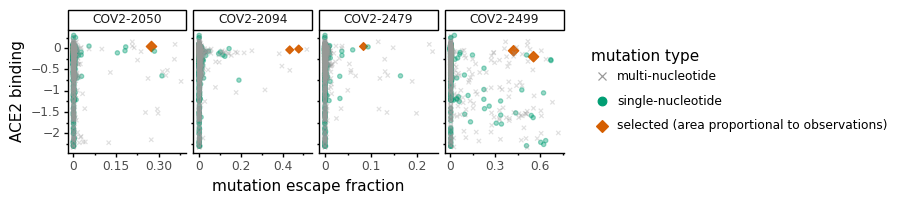

In [7]:
max_selected = escape_dms_selection['n_selected'].max()
n_antibodies = escape_dms_selection['antibody'].nunique()


# assign area for points, proportional to n_selected but always at least 0.5 so even
# unselected points are visible, and categorize points by not single-nucleotide accessible,
# single-nucleotide accessible and no-escape, or escape
cat_labels = {0: 'multi-nucleotide',
              1: 'single-nucleotide',
              2: 'selected (area proportional to observations)',
              }
df = escape_dms_selection.assign(
        point_area=lambda x: numpy.clip(x['n_selected'], 0.5, None),
        # 0 for not single-nt accessible, 1 for single-nt accessible but not selected, 2 for selected and single-nt accessible
        point_category_int=lambda x: x['any_selected'].astype(int) + x['single_nt_accessible'],
        point_category=lambda x: pd.Categorical(x['point_category_int'].map(cat_labels), cat_labels.values(), ordered=True)
        )
assert not len(df.query('any_selected and not single_nt_accessible')), 'categories above do not work'
    
p = (ggplot(df) +
     aes('mutation_escape', 'ACE2 binding',
         color='point_category', alpha='point_category',
         size='point_area', shape='point_category') +
     geom_point() +
     facet_wrap('~ antibody', nrow=1, scales='free_x') +
     scale_color_manual(values=[CBPALETTE[0], CBPALETTE[3], CBPALETTE[6]]) +
     scale_alpha_manual(values=[0.3, 0.4, 0.95]) +
     scale_size_area(max_size=2.5) +
     scale_shape_manual(values=['x', 'o', 'D']) +
     theme_classic() +
     scale_x_continuous(name='mutation escape fraction',
                        breaks=mizani.breaks.mpl_breaks(nbins=3),
                        ) +
     guides(alpha=False, size=False,
            shape=guide_legend(override_aes={'size': 3},
                               title='mutation type'),
            color=guide_legend(title='mutation type'),
            ) +
     theme(figure_size=(1.6 * n_antibodies, 1.6))
    )
     
_ = p.draw()